# DeePC Implementation

### Packages

In [119]:
import osqp
import cvxpy as cp
import numpy as np

import scipy as sp
from scipy import sparse

import matplotlib.pyplot as plt
from scipy.linalg import hankel
%matplotlib inline

## Recht system

In [120]:
A = np.array([[1.01, 0.01, 0.00], # A - State-space matrix
              [0.01, 1.01, 0.01], 
              [0.00, 0.01, 1.01]]) 
B = np.eye(3) # B - State-space matrix
C = np.eye(3) # C - State-space matrix
D = np.zeros([3,3]) # D - State-space matrix

n = A.shape[0] # n = number of states
m = B.shape[1] # m = number of inputs
p = C.shape[0] # p = number of output
q = m+p # q = number of i/o variables

Tini = 3                                   # Past time horizon                                           
Tf = 3                                     # Future time horizon         
T = (m+1)*(Tini + Tf + n) - 1                               


## Data Collection

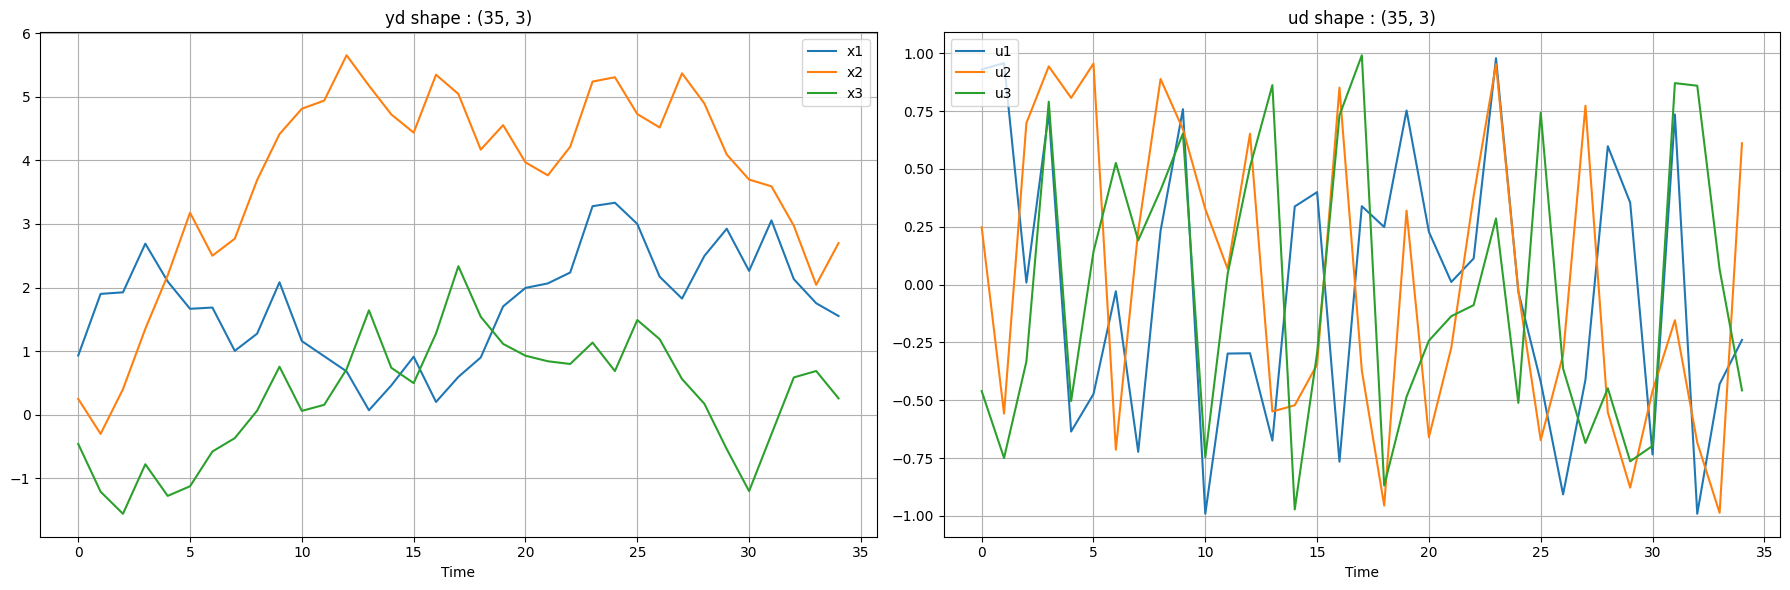

In [121]:
ud = []
yd = []
x = np.array([0,0,0])
for i in range(T):
   u = np.random.uniform(low=-1, high=1, size=(m,)) # Random input
   x = A@x + B@u
   y = C@x + D@u
   ud.append(u)
   yd.append(y)
ud = np.array(ud)
yd = np.array(yd)

# print(f'ud shape : {ud.shape}, yd shape : {yd.shape}')
plt.rcParams["figure.figsize"] = (18,6)
plt.subplot(1,2,1)
plt.plot(range(0,35), yd, label=['x1', 'x2', 'x3'])
plt.legend(loc="upper right")
plt.xlabel('Time')
plt.title(f"yd shape : {yd.shape}")
plt.grid('on')
plt.tight_layout()

plt.subplot(1,2,2)
plt.plot(range(0,35), ud, label=['u1', 'u2', 'u3'])
plt.legend(loc="upper left")
plt.xlabel('Time')
plt.title(f"ud shape : {ud.shape}")
plt.grid('on')
plt.tight_layout()

plt.show()

In [122]:
L = Tini + Tf + n
u_row, u_col = ud.shape
H_u = np.zeros((m*L, T-L+1))
ud = ud.reshape((u_row*u_col,))
for i in range(0,T-L+1):
   H_u[:,i] = ud[m*i:m*(L+i)]
print(f'H has rank {np.linalg.matrix_rank(H_u)} and shape {H_u.shape}')

H has rank 27 and shape (27, 27)


In [123]:
L = Tini + Tf
U = np.zeros((m*L, T-L+1))
for i in range(0,T-L+1):
   U[:,i] = ud[m*i:m*(L+i)]

y_row, y_col = yd.shape
yd = yd.reshape((y_row * y_col,))

Y = np.zeros((p*L, T-L+1))
for i in range(0,T-L+1):
   Y[:,i] = yd[p*i:p*(L+i)]

In [124]:
u_ini = np.zeros(Tini*m)
y_ini = np.zeros(Tini*p)

In [125]:
print(Y.shape)
print(U.shape)

(18, 30)
(18, 30)


In [126]:
Up = U[0:m*Tini,:]
Yp = Y[0:p*Tini,:]
Uf = U[Tini*m:,:]
Yf = Y[Tini*p:,:]
print(f'Up shape : {Up.shape}, Yp shape : {Yp.shape}, Uf shape : {Uf.shape}, Yf shape: {Yf.shape}')

Up shape : (9, 30), Yp shape : (9, 30), Uf shape : (9, 30), Yf shape: (9, 30)


## Solver

In [127]:
u = cp.Variable(Tf*m)
g = cp.Variable(T-Tini-Tf+1)
y = cp.Variable(Tf*p)

Q = np.eye(Tf*p)*10
r = np.kron(np.ones(Tf), np.array([-8,5,8]))
R = np.eye(Tf*m)*1

uT = [*u_ini]
yT = [*y_ini]

cost = cp.quad_form(y-r,Q) + cp.quad_form(u,R)

for i in range(0,10):
    constraints = [
        Up@g == u_ini,
        Yp@g == y_ini,
        Uf@g == u,
        Yf@g == y,
        cp.abs(u) <= 1.5
    ]

    prob = cp.Problem(cp.Minimize(cost), constraints)
    prob.solve(solver=cp.OSQP, verbose=False)

    action = prob.variables()[1].value[:m]
    obs = A@y_ini[-p:] + action
    yT = np.append(yT, obs)
    uT = np.append(uT, action)
    u_ini = uT[-m*Tini:]
    y_ini = yT[-p*Tini:]



## Visualisation

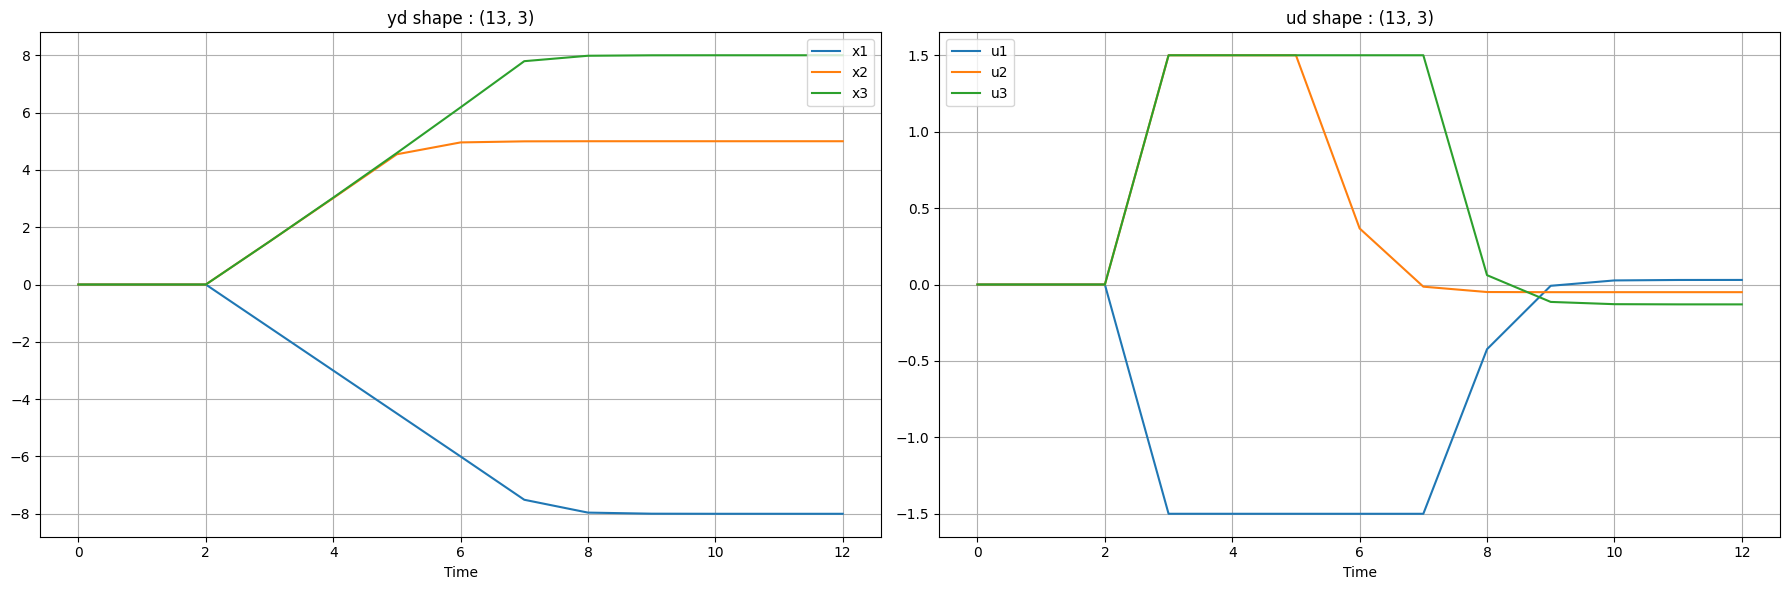

[[-8.00001544  4.99988822  7.99990386]
 [-8.00003844  4.99988797  7.99991355]]
[[ 0.02997828 -0.04999802 -0.12998822]]


In [128]:
plt.rcParams["figure.figsize"] = (18,6)
yT, uT = np.array(yT), np.array(uT)

yT = yT.reshape((13,3))
uT = uT.reshape((13,3))
plt.subplot(1,2,1)
plt.plot(range(0,13), yT, label=['x1', 'x2', 'x3'])
# plt.plot(range(0,3), )
plt.legend(loc="upper right")
plt.xlabel('Time')
plt.title(f"yd shape : {yT.shape}")
plt.grid('on')
plt.tight_layout()

plt.subplot(1,2,2)
plt.plot(range(0,13), uT, label=['u1', 'u2', 'u3'])
plt.legend(loc="upper left")
plt.xlabel('Time')
plt.title(f"ud shape : {uT.shape}")
plt.grid('on')
plt.tight_layout()

plt.show()

print(yT[-2:,:])
print(uT[-1:,:])

In [129]:
x = np.array([-8.00001544,  4.99988822,  7.99990385])
u = np.array([0.02997828, -0.04999802, -0.12998822])
A = np.array([[1.01, 0.01, 0.00], # A - State-space matrix
              [0.01, 1.01, 0.01], 
              [0.00, 0.01, 1.01]]) 
A@x + u

array([-8.00003843,  4.99988797,  7.99991355])

In [130]:
A = np.array([
    [1,1,1,1],
    [2,2,2,2],
    [3,3,3,3],
    [4,4,4,4],
    [5,5,5,5],
    [6,6,6,6],
    [7,7,7,7],
])

# Get shape of A
(row,col) = A.shape
A = A.reshape((row*col,))

# Define L and T
L = 2
T = 7

# Fill in Hankel
H = np.zeros((L*col, T-L+1))
for i in range(0,T-L+1):
    H[:,i] = A[4*i:4*(L+i)]
H

array([[1., 2., 3., 4., 5., 6.],
       [1., 2., 3., 4., 5., 6.],
       [1., 2., 3., 4., 5., 6.],
       [1., 2., 3., 4., 5., 6.],
       [2., 3., 4., 5., 6., 7.],
       [2., 3., 4., 5., 6., 7.],
       [2., 3., 4., 5., 6., 7.],
       [2., 3., 4., 5., 6., 7.]])